In [ ]:
%pip install -q diffusers

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, CosineDPMSolverMultistepScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Using device: cuda


In [ ]:
dataset = torchvision.datasets.FashionMNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:02<00:00, 12791415.64it/s]


Extracting mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202706.83it/s]


Extracting mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1880732.03it/s]


Extracting mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5918935.58it/s]

Extracting mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw



In [ ]:
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

Input shape: torch.Size([128, 1, 28, 28])
Labels: tensor([7, 7, 0, 1, 1, 0, 6, 4, 9, 9, 6, 3, 5, 8, 6, 2, 7, 7, 7, 9, 3, 3, 7, 3,
        4, 6, 4, 4, 0, 4, 2, 0, 8, 4, 1, 8, 7, 3, 6, 9, 8, 7, 0, 5, 6, 4, 9, 6,
        3, 3, 8, 2, 2, 6, 1, 0, 7, 7, 1, 9, 2, 0, 7, 7, 7, 1, 8, 5, 0, 5, 6, 9,
        7, 8, 5, 4, 2, 8, 4, 7, 6, 1, 3, 0, 4, 2, 1, 3, 4, 2, 6, 3, 2, 1, 5, 9,
        2, 7, 6, 5, 2, 6, 2, 0, 8, 5, 5, 4, 3, 1, 1, 1, 2, 0, 5, 7, 2, 4, 5, 9,
        7, 0, 0, 2, 3, 6, 2, 7])


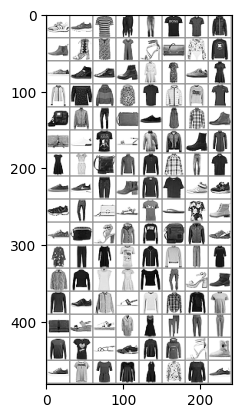

In [ ]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

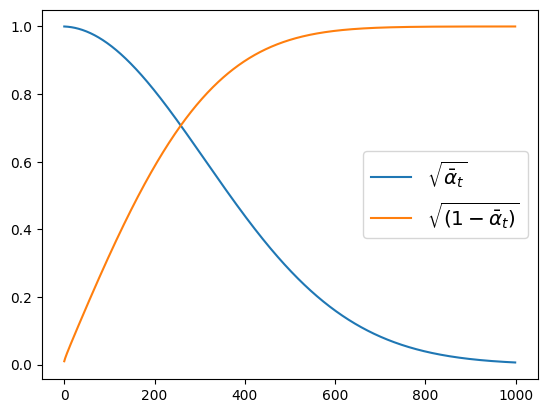

In [ ]:
#noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,      # Number of diffusion steps
    beta_start=0.0001,             # Start of beta schedule
    beta_end=0.02,                 # End of beta schedule
    beta_schedule="linear",        # Beta schedule type ("linear", "scaled_linear", "squaredcos_cap_v2", etc.)
)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Epoch [1/5] Batch 0/469 Loss: 1.1278
Epoch [1/5] Batch 100/469 Loss: 0.0535
Epoch [1/5] Batch 200/469 Loss: 0.0465
Epoch [1/5] Batch 300/469 Loss: 0.0695
Epoch [1/5] Batch 400/469 Loss: 0.0559
Finished epoch 1. Average loss for this epoch: 0.070151
Epoch [2/5] Batch 0/469 Loss: 0.0664
Epoch [2/5] Batch 100/469 Loss: 0.0484
Epoch [2/5] Batch 200/469 Loss: 0.0498
Epoch [2/5] Batch 300/469 Loss: 0.0432
Epoch [2/5] Batch 400/469 Loss: 0.0486
Finished epoch 2. Average loss for this epoch: 0.047265
Epoch [3/5] Batch 0/469 Loss: 0.0515
Epoch [3/5] Batch 100/469 Loss: 0.0421
Epoch [3/5] Batch 200/469 Loss: 0.0569
Epoch [3/5] Batch 300/469 Loss: 0.0453
Epoch [3/5] Batch 400/469 Loss: 0.0423
Finished epoch 3. Average loss for this epoch: 0.043914
Epoch [4/5] Batch 0/469 Loss: 0.0509
Epoch [4/5] Batch 100/469 Loss: 0.0391
Epoch [4/5] Batch 200/469 Loss: 0.0434
Epoch [4/5] Batch 300/469 Loss: 0.0430
Epoch [4/5] Batch 400/469 Loss: 0.0400
Finished epoch 4. Average loss for this epoch: 0.042152
Epoc

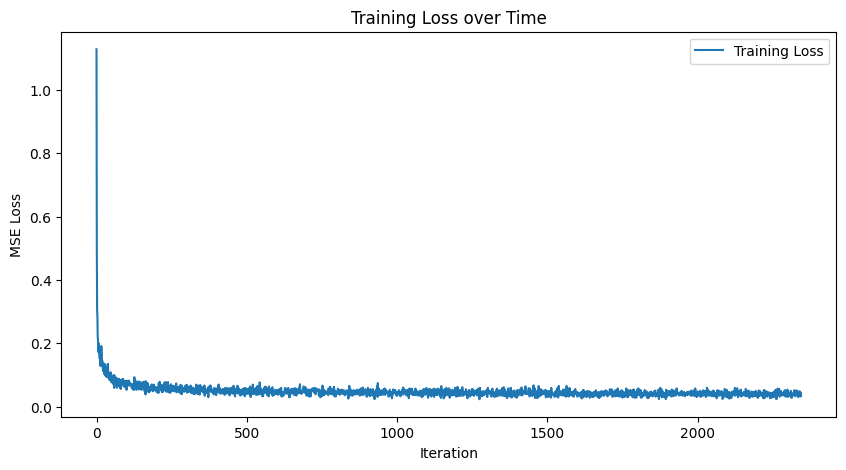

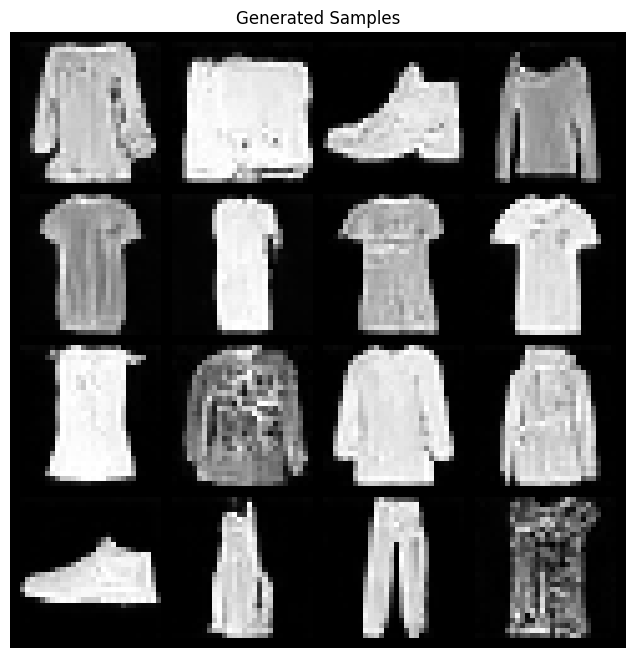

In [ ]:
#Defining the UNet2DModel
model = UNet2DModel(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 64),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
)
model.to(device)

#Defining Loss and Optimizer
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

losses = []

#Training Loop
n_epochs = 5
for epoch in range(n_epochs):
    for batch_idx, (x, _) in enumerate(train_dataloader):
        x = x.to(device)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (x.size(0),), device=device)

        # Sample Gaussian noise
        noise = torch.randn_like(x).to(device)

        # Add noise to the images
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Predict the noise residual
        pred_noise = model(noisy_x, timesteps).sample

        # Compute the loss between predicted noise and actual noise
        loss = loss_fn(pred_noise, noise)

        # Backpropagation and optimization
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Record the loss
        losses.append(loss.item())

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}] Batch {batch_idx}/{len(train_dataloader)} Loss: {loss.item():.4f}")

    # Calculate and print the average loss for the epoch
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f'Finished epoch {epoch+1}. Average loss for this epoch: {avg_loss:.6f}')

#Plot Training Losses
plt.figure(figsize=(10,5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Time')
plt.legend()
plt.show()

#Sampling Function
@torch.no_grad()
def sample(model, noise_scheduler, device, batch_size=64, image_size=(1, 28, 28)):
    model.eval()
    # Initialize with pure noise
    x = torch.randn(batch_size, *image_size).to(device)

    for t in reversed(range(noise_scheduler.config.num_train_timesteps)): # Going from the back
        # Create a batch of timesteps
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)

        # Predict the noise residual
        pred_noise = model(x, t_batch).sample

        # Compute the previous sample (denoised)
        step_output = noise_scheduler.step(pred_noise, t, x)

        # Update x to the previous step
        x = step_output.prev_sample

    return x

# Generate and Visualize Samples
samples = sample(model, noise_scheduler, device)
samples = samples.cpu()

# Denormalize the images for visualization
samples = (samples * 0.5) + 0.5

# Create a grid of images
grid = torchvision.utils.make_grid(samples[:16], nrow=4)

# Plot the grid
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
plt.title('Generated Samples')
plt.axis('off')
plt.show()
